In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit

In [2]:
def input_data(Nx,Ny,rmin):
    
    #Nx= Nuber of elements in X dire
    #Ny= Number of elements in Y dire
    #NN= Array with node numbers( Ny+1,Nx+1)
    #dom= Array with co-ordiantes of all nodes iwth X- row and Y- column
    #XDOF= DOF matrix(Ny+1,Nx+1) contains DOF in X dir
    #YDOF= DOF matrix(Ny+1,Nx+1) contains DOF in Y dir
    
    
    X=np.linspace(0,Nx,Nx+1);
    Y=np.linspace(0,Ny,Ny+1);
    dom=np.empty((Ny+1,Nx+1), dtype=object);
    
    
    for i in range(0,Ny+1):
        for j in range(0,Nx+1):
            dom[i,j]=(X[j],Y[i])
    
    
            
    n=np.linspace(1,(Nx+1)*(Ny+1),((Nx+1)*(Ny+1)));# total number of nodes
    
    NN=np.reshape(n,(Ny+1,Nx+1)).T;# n is reshape to get nodal matrix
    #DOF=np.linspace(1,2*(Nx+1)*(Ny+1),2*(Nx+1)*(Ny+1));
    #XDOF=DOF[0:2*(Nx+1)*(Ny+1)-1:2].reshape(Ny+1,Nx+1);
    #YDOF=DOF[1:2*(Nx+1)*(Ny+1):2].reshape(Ny+1,Nx+1);

        
    # Element matrix
    # Element=[Nx*Ny,4]: Num of elements X 4 node_numbers
    Element=np.zeros((Ny*Nx,4));
    Element_DOF=np.zeros((Ny*Nx,8));
    Element_cen=np.empty((Ny*Nx), dtype=object)
    k=0;
    for i  in range (0,Ny):
        for j in range (0,Nx):
            
            Element[k,:]=[NN[i+1,j], NN[i+1,j+1] ,NN[i,j+1] ,NN[i,j] ]
            
            Element_DOF[k,:]=[ NN[i+1,j]*2-1, NN[i+1,j]*2, NN[i+1,j+1]*2-1, NN[i+1,j+1]*2,NN[i,j+1]*2-1,NN[i,j+1]*2,NN[i,j]*2-1,NN[i,j]*2]
            k=k+1;
    

    for i in range (0, Nx*Ny):
        
        P0=dom[np.where(NN==Element[i,0])[0],np.where(NN==Element[i,0])[1]]
        P1=dom[np.where(NN==Element[i,1])[0],np.where(NN==Element[i,1])[1]]
        P2=dom[np.where(NN==Element[i,2])[0],np.where(NN==Element[i,2])[1]]
        P3=dom[np.where(NN==Element[i,3])[0],np.where(NN==Element[i,3])[1]]
        Element_cen[i]= (np.average([P0[0][0],P1[0][0],P2[0][0],P3[0][0]]),np.average([P0[0][1],P1[0][1],P2[0][1],P3[0][1]]))
    
    H_ele=np.zeros((Nx*Ny,Nx*Ny))
    
    for i in range (0, Nx*Ny):
        for j in range(0,Nx*Ny):
            X0=Element_cen[i][0]
            X1=Element_cen[j][0]
            Y0=Element_cen[i][1]
            Y1=Element_cen[j][1]
            r= np.sqrt((Y1-Y0)**2+(X1-X0)**2)
            if r<=rmin:
                H_ele[j,i]=rmin-r
                              
    return NN,Element_DOF,H_ele


def Stiffness_local(nu):
    # As dimensions of all elements are same, Local stiffness matrix for every element will be same
    #KE is generated for the plane stress elements.
    
    A11=np.array([[12,3 ,-6 ,-3], [3 ,12, 3, 0], [-6 ,3, 12, -3],[-3 ,0 ,-3, 12]]);
    A12=np.array([[-6, -3 ,0 ,3], [-3 ,-6, -3, -6],[ 0, -3, -6 ,3],[3 ,-6, 3, -6]]);
    B11=np.array([[-4, 3 ,-2, 9],[3, -4 ,-9 ,4], [-2, -9 ,-4 ,-3], [9, 4, -3, -4]]);
    B12=np.array([[2, -3, 4, -9],[-3, 2 ,9, -2] , [4, 9, 2, 3], [-9, -2, 3, 2]]);
    A=np.concatenate((A11 ,A12),axis=1)
    B=np.concatenate((A12.T ,A11),axis=1)
    C=np.concatenate((A ,B),axis=0)
    A=np.concatenate((B11, B12),axis=1)
    B=np.concatenate((B12.T ,B11),axis=1)
    D=np.concatenate((A ,B),axis=0)
    
    KE=(1/(24*(1-nu*nu)))*(C+ nu*D);
                           
    return KE


def Global_Stifffness(K_local, Element_DOF,NN,density):
    
    X=density.reshape((Nx*Ny,))
    X=Emin+(X**penal)*(Eo-Emin)
    KG=np.zeros(((2*NN.shape[0]*NN.shape[1]),(2*NN.shape[0]*NN.shape[1])));
    #print(KG.shape)
    for ele in range (Nx*Ny):
        p_indices = Element_DOF[ele,:].astype(int)-1
        KG[np.ix_(p_indices, p_indices)] += X[ele] * K_local
       
    return KG


def BC(Node, Node_DOF):
    #func: This fucntion takes all the nodes and nodes_DOF and gives the segregated DOF as per Sigmund(99 code)
    #input= Node( all nodes of structure), Node_DOF= All DOF of th nodes
    
    D1=np.array([Node[0,0]*2-1,Node[0,0]*2, Node[0,-1]*2-1,Node[0,-1]*2,Node[-1,-1]*2-1,Node[-1,-1]*2,Node[-1,0]*2-1,Node[-1,0]*2])
    nd3=np.concatenate((Node[1:-1,-1],Node[ 0,1:-1]),axis=0)
    a=[[2*i-1,2*i] for i in nd3]
    aa=[]
    for i in range(len(a)):
        aa=aa+a[i]
    D3=np.array(aa)
    nd4=np.concatenate((Node[1:-1,0],Node[-1,1:-1]),axis=0)
    a=[[2*i-1,2*i] for i in nd4]
    aa=[]
    for i in range(len(a)):
        aa=aa+a[i]
    D4=np.array(aa)
    D4_flattened=D4.flatten()
    D3_flattened=D3.flatten()
    D1_flattened=D1.flatten()
    D134=np.concatenate((D1_flattened,D4_flattened,D3_flattened))
    D2=np.setdiff1d(Node_DOF, D134)
    D3dup=D4.copy()
    D4=D3
    D3=D3dup
    
    return D1,D2,D3,D4

def PBC(Nx,Ny):
    #func: This fucntion generated the dispalcement at four nodes and for edge nodes as per unti strain field
    #input=NIL
    #output= Displacement of four corner nodes and edge nodes that eprtain the ( D3/D4)
    #brief: This function evaluates the displacement for a unit cell for a unit strain field
    #[0 1 2 3 4 5 6 7],[2,3]= top right edge node,[4,5]= diagonal node,[6,7]: Y direction node
    
    NNx=Nx-1 # indicates the number of nodes in the edges apart from the end nodes
    NNy=Ny-1
    eo=np.array([[1,0,0],[0,1,0],[0,0,1]]) # unit strain field
    U=np.zeros((8,3))
    for j in range(3):
        
        U[4:6,j]=np.dot(np.array([[eo[0,j],eo[2,j]*0.5],[eo[2,j]*0.5,eo[1,j]]]),np.array([[Nx],[0]])).reshape(1,-1)
        U[0:2,j]=np.dot(np.array([[eo[0,j],eo[2,j]*0.5],[eo[2,j]*0.5,eo[1,j]]]),np.array([[0],[Ny]])).reshape(1,-1)
        U[2:4,j]=U[4:6,j]+ U[0:2,j]
    
    wfixed=np.zeros(((NNx)*2+(NNy)*2,3))
    for i in range(0,2*NNx,2):
        wfixed[i,:]=U[4,:]
    
    for i in range(1,2*NNx,2):
        wfixed[i,:]=U[5,:]
      
    for i in range(0,2*NNy,2):
        wfixed[i+2*NNx,:]=U[0,:]
    
    for i in range(1,2*NNy,2):
        wfixed[i+2*NNx,:]=U[1,:] 
        
    
    return U, wfixed

def analysis(U1,wfixed,D_1,D_2,D_3,D_4,K_add):

    D1=D_1.copy().astype(int)-1
    D2=D_2.copy().astype(int)-1
    D3=D_3.copy().astype(int)-1
    D4=D_4.copy().astype(int)-1

    K22=K_add[D2,:][:,D2]
    K23=K_add[D2,:][:,D3]
    K24=K_add[D2,:][:,D4]
    K33=K_add[D3,:][:,D3]
    K34=K_add[D3,:][:,D4]
    K43=K_add[D4,:][:,D3]
    K44=K_add[D4,:][:,D4]
    K21=K_add[D2,:][:,D1]
    K31=K_add[D3,:][:,D1]
    K41=K_add[D4,:][:,D1]
    K32=K_add[D3,:][:,D2]
    K42=K_add[D4,:][:,D2]
    
    K1=np.concatenate((K22,K23+K24),axis=1)
    K2=np.concatenate((K32+K42,K33+K34+K43+K44),axis=1)
    K_new=np.concatenate((K1,K2),axis=0)
    K_U1=np.concatenate((K21,K31+K41),axis=0)
    K_W1=np.concatenate((K24,K34+K44),axis=0)
    
    U23=np.zeros((D2.shape[0]+D3.shape[0],3))

    
    A = -(np.dot(K_U1, U1) + np.dot(K_W1, wfixed))
    K_inv = np.linalg.inv(K_new)
    U23 = np.dot(K_inv, A)
    
    disp=np.zeros(((Nx+1)*(Ny+1)*2,3))
    
    disp[D1,:]=U1
    disp[D2,:]=U23[0:D2.shape[0],:]
    disp[D3,:]=U23[D2.shape[0]:,:]
    disp[D4,:]=U23[D2.shape[0]:,:]+wfixed

        
    return disp


def initial_Density(Nx,Ny,volfrac):
    #brief: This function evaluates the initial density of the 2D material. It is coded as softer material at center 
    #and harder material on the outer face
    #it evaluates the distance between the center of eleement to center of domain and it should be less than 1/3 rd of the 
    #total length
    X= np.zeros((Ny,Nx))
    for i in range(Nx):
        for j in range(Ny):
            if np.sqrt((j+0.5-Ny*0.5)**2+(i+0.5-Nx*0.5)**2)<(np.minimum(Nx,Ny)/3):
                X[j,i]=volfrac*0.5
            else:
                X[j,i]=volfrac
    return X

def strain_energy(disp,Element_DOF,density):
    
    X=density.reshape((Nx*Ny,))
    
    # calculation of element stiffness matrix
    DOF=Element_DOF.copy()-1
    DOF=DOF.astype(int)
    K_e=Stiffness_local(nu)
    
    # initialization of mutual energies
    q=np.zeros((Ny*Nx,))
    dQ=np.zeros((Ny*Nx,9))
    #dq= matrix containing all the energies for elements for particualr strain
    #dq[:,0]: referes to the energies of elements corresponding to E11
    #dq[:,1]:E12, dq[:,2]:E13
    
    Q=np.zeros((3,3))
    kk=0
    for i in range(3):
        for j in range(3):
            for element in range(Nx*Ny):
                UTK=np.dot(disp[DOF[element,:],i].T,K_e)
                q[element]=np.dot(UTK,disp[DOF[element,:],j])/(Nx*Ny)
                dQ[element,kk]=q[element]*(penal*(Eo-Emin)*X[element]**(penal-1))               
                q[element]=q[element]*(Emin+(X[element]**penal)*(Eo-Emin))
            # THis is meant for calculation of C(compliance)
            Q[i,j]=np.sum(q)
            kk=kk+1
    
    # from this line calcualtion of C, dC and dV commences
   
    C=Q[0,1]-((0.8**loop)*(Q[0,0]+Q[1,1]))
    dC=dQ[:,1]-((0.8**loop)*(dQ[:,0]+dQ[:,4]))
    
    dV=np.ones((Nx*Ny,))
    
    return C,dC,dV
    
    
def filteration(C_der,V_der,H_ele,density):
    X=density.copy().reshape((Nx*Ny,))
    B=np.full((Ny*Nx,),1e-3)
    dC=np.zeros((Ny*Nx,))
    
    if ft==1:
        for i in range(Nx*Ny):
            H_sum=np.sum(H_ele[:,i])
            dC[i]=np.sum(C_der*H_ele[:,i]*X)/(np.maximum(1e-9,X[i]))
            dC[i]=dC[i]/H_sum
        
    elif ft==2:
        for i in range(Nx*Ny):
            H_sum=np.sum(H_ele[:,i])
            C_der=C_der*H_ele[:,i]/H_sum
            V_der=V_der*H_ele[:,i]/H_sum
    elif ft==0:
        C_der=C_der
        V_der=V_der
        
    return dC,V_der
        
    
def optimal_criteria(C_der,V_der,den,H_ele):
    Xd=den.copy().reshape((Nx*Ny,))
    move=0.2
    l1=0
    l2=1E+9
    f1=np.ones((Xd.shape[0],))
    f0=np.zeros((Xd.shape[0],))
    while (l2-l1)>1e-9:
        lmid=0.5*(l1+l2)
        Be=-dC/(dV*lmid)
        a=np.minimum(Xd+move,Xd*(-C_der/(V_der*lmid)))
        b=np.minimum(f1,a)
        c=np.maximum(Xd-move,b)
        Xd_new=np.maximum(f0,c)
        
        if np.mean(Xd_new) > volfrac:
            l1=lmid
        else:
            l2=lmid
  
  
                
    if ft==1:
        Xd_new=Xd_new
    elif ft==2:
        for i in range(Nx*Ny):
                H_sum=np.sum(H_ele[:,i])
                Xd_new=Xd_new*H_ele[:,i]/H_sum
    else:
        Xd_new=Xd_new
        
    Xd_new=Xd_new.reshape((Ny,Nx))
    
    return Xd_new
                
            

Loop:1 change :0.2 mean_Density : 0.49999981248874464 Compliance :-0.09828531439173085


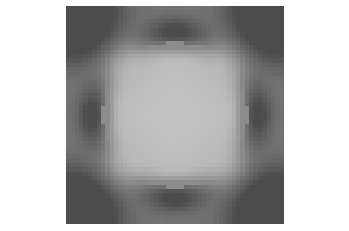

Loop:2 change :0.19999999999999996 mean_Density : 0.5000004225084282 Compliance :-0.13992776009638996


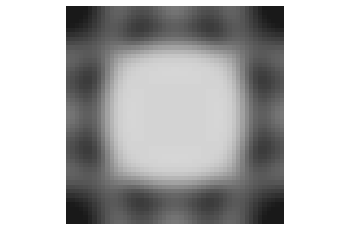

Loop:3 change :0.20000000000000007 mean_Density : 0.5000003457929714 Compliance :-0.1203662668258576


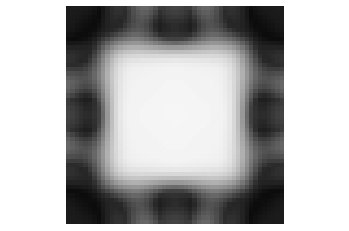

Loop:4 change :0.20000000000000007 mean_Density : 0.4999999202263474 Compliance :-0.12215871434193573


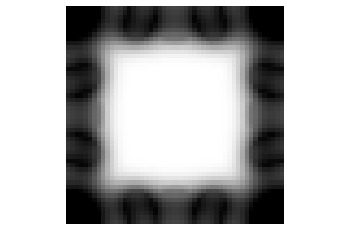

Loop:5 change :0.20000000000000007 mean_Density : 0.5000001117757404 Compliance :-0.1161212582262893


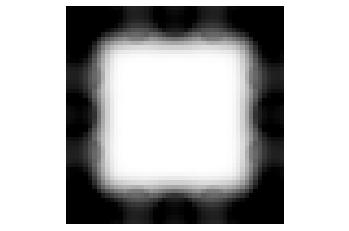

Loop:6 change :0.20000000000000007 mean_Density : 0.5000003799997336 Compliance :-0.09931947801279346


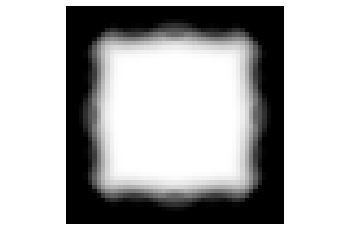

Loop:7 change :0.20000000000000007 mean_Density : 0.49999995413006726 Compliance :-0.08029629198977645


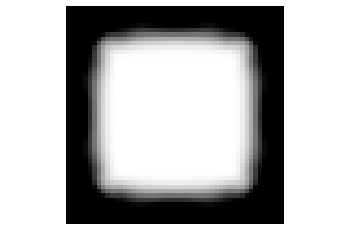

Loop:8 change :0.2 mean_Density : 0.4999996681124462 Compliance :-0.05931582415343342


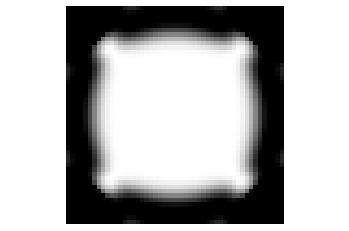

Loop:9 change :0.20000000000000007 mean_Density : 0.5000004216269618 Compliance :-0.04227698139389327


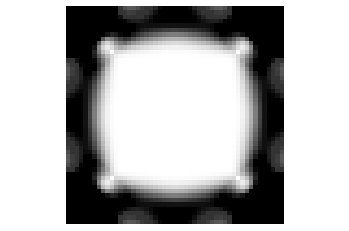

Loop:10 change :0.20000000000000007 mean_Density : 0.49999759306242497 Compliance :-0.029898357784231958


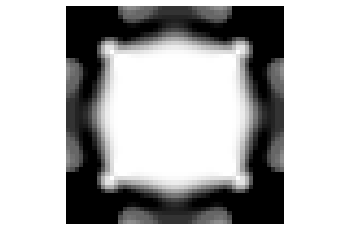

Loop:11 change :0.20000000000000007 mean_Density : 0.5000006680674495 Compliance :-0.021557923226850184


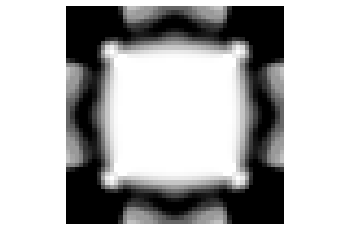

Loop:12 change :0.20000000000000007 mean_Density : 0.49999439274531277 Compliance :-0.015743409672439212


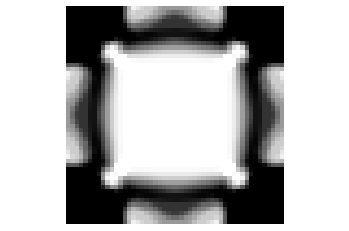

Loop:13 change :0.20000000000000007 mean_Density : 0.5000042785259964 Compliance :-0.012542933710967426


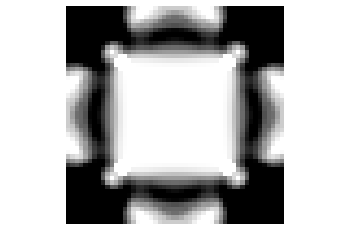

Loop:14 change :0.20000000000000007 mean_Density : 0.5000060460303586 Compliance :-0.010241832611148834


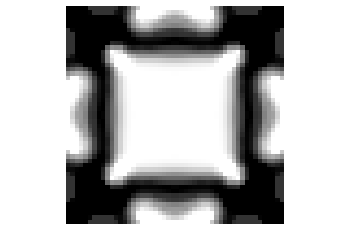

Loop:15 change :0.20000000000000007 mean_Density : 0.5000005552094999 Compliance :-0.009677346153179566


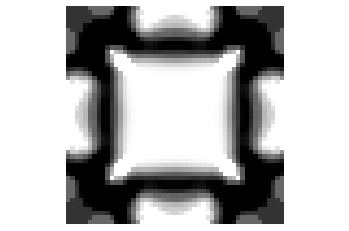

Loop:16 change :0.20000000000000007 mean_Density : 0.49999893285574487 Compliance :-0.01111075385011135


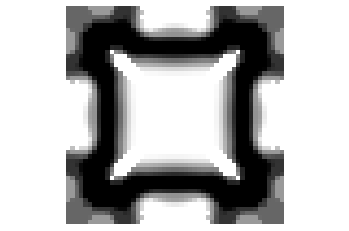

Loop:17 change :0.20000000000000007 mean_Density : 0.49999858021506605 Compliance :-0.01145425411609624


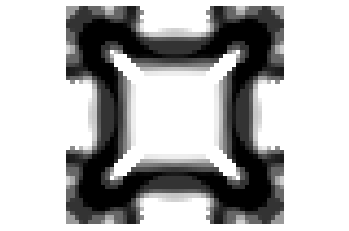

Loop:18 change :0.20000000000000007 mean_Density : 0.49999998085360803 Compliance :-0.01226291940627188


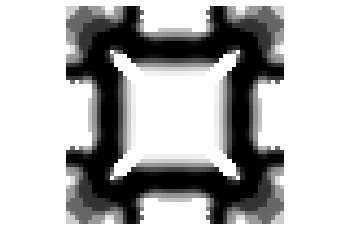

Loop:19 change :0.20000000000000007 mean_Density : 0.4999996264748281 Compliance :-0.017147596188864956


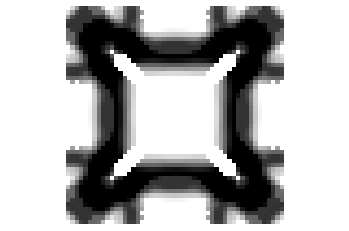

Loop:20 change :0.20000000000000007 mean_Density : 0.500001504773072 Compliance :-0.011740799528244647


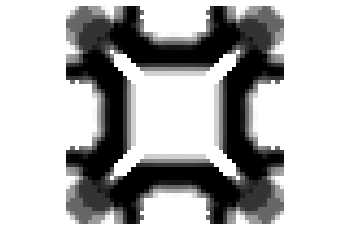

Loop:21 change :0.20000000000000007 mean_Density : 0.500000999055975 Compliance :-0.019470417367663393


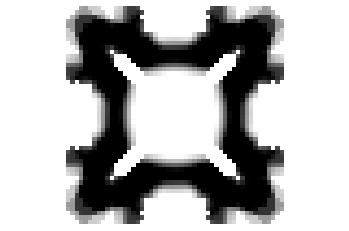

Loop:22 change :0.20000000000000007 mean_Density : 0.5000017508644504 Compliance :-0.02299498557675797


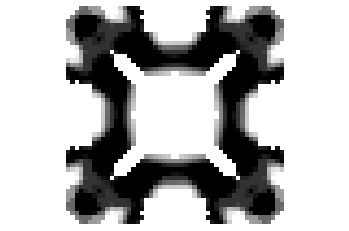

Loop:23 change :0.20000000000000007 mean_Density : 0.5000009670185943 Compliance :-0.023066533061312386


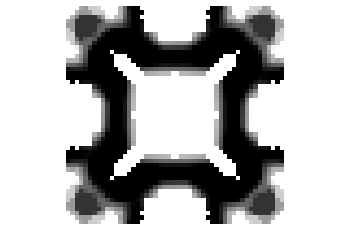

Loop:24 change :0.20000000000000007 mean_Density : 0.5000010419802873 Compliance :-0.019095337370344564


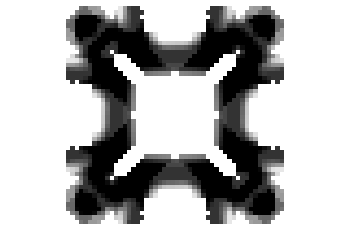

Loop:25 change :0.20000000000000007 mean_Density : 0.4999993659698925 Compliance :-0.01904146831716775


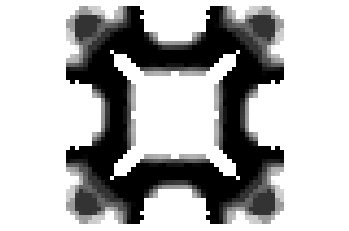

Loop:26 change :0.20000000000000007 mean_Density : 0.5000007136912643 Compliance :-0.01840463972893287


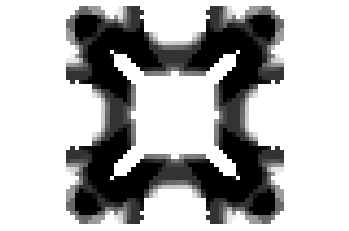

Loop:27 change :0.20000000000000007 mean_Density : 0.500000476592043 Compliance :-0.018184162998418373


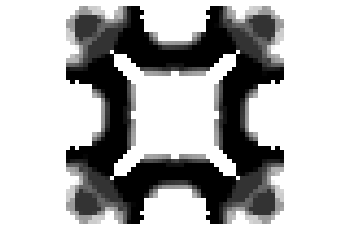

Loop:28 change :0.20000000000000007 mean_Density : 0.5000012845975865 Compliance :-0.016783443139422677


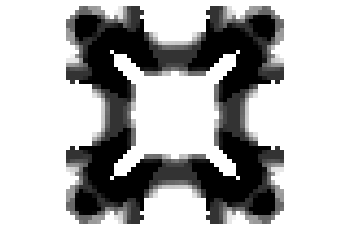

Loop:29 change :0.20000000000000007 mean_Density : 0.49999931544749704 Compliance :-0.01774009874021436


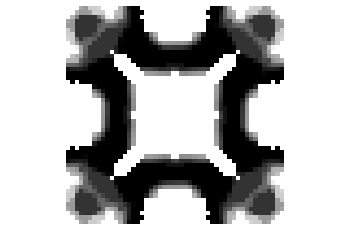

Loop:30 change :0.20000000000000007 mean_Density : 0.5000013872744766 Compliance :-0.017130744702926904


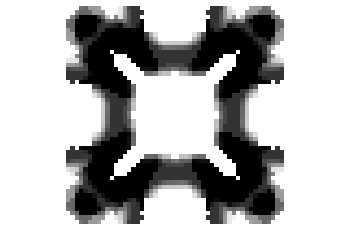

Loop:31 change :0.20000000000000007 mean_Density : 0.49999978199916684 Compliance :-0.017540600094137958


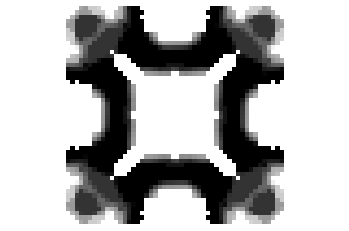

Loop:32 change :0.20000000000000007 mean_Density : 0.4999998101318676 Compliance :-0.017278342591304834


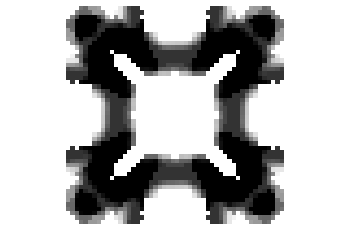

Loop:33 change :0.20000000000000007 mean_Density : 0.4999999781682715 Compliance :-0.017443852100759508


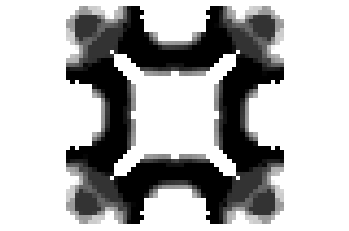

Loop:34 change :0.20000000000000007 mean_Density : 0.5000010174096551 Compliance :-0.01724043519712053


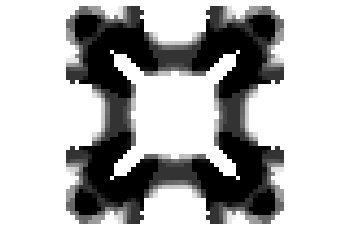

Loop:35 change :0.20000000000000007 mean_Density : 0.4999993373503222 Compliance :-0.01739158880884967


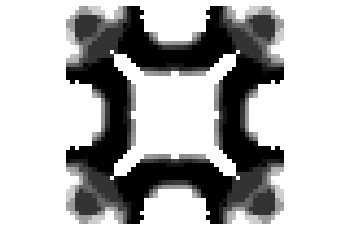

Loop:36 change :0.20000000000000007 mean_Density : 0.5000006319064373 Compliance :-0.017225656418306305


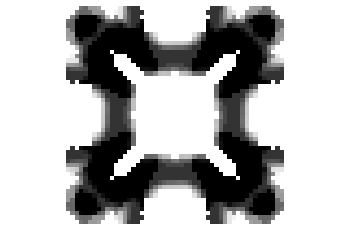

Loop:37 change :0.20000000000000007 mean_Density : 0.4999993460767844 Compliance :-0.017360319975533594


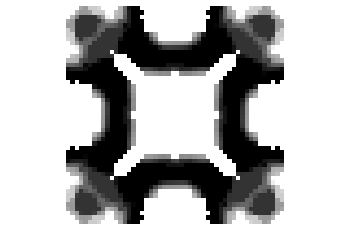

Loop:38 change :0.20000000000000007 mean_Density : 0.5000015708868883 Compliance :-0.01721360704563463


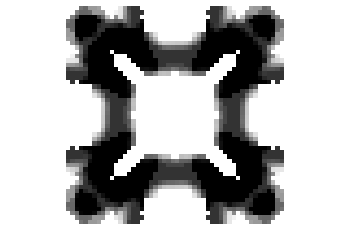

Loop:39 change :0.20000000000000007 mean_Density : 0.5000002684883841 Compliance :-0.017340423086433854


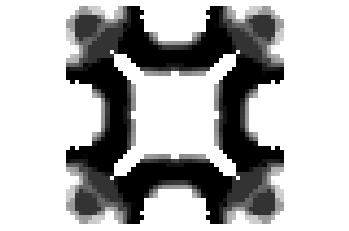

Loop:40 change :0.20000000000000007 mean_Density : 0.5000002447700194 Compliance :-0.01720563745211466


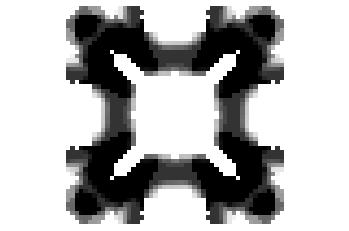

Loop:41 change :0.20000000000000007 mean_Density : 0.5000004378489803 Compliance :-0.017327614160638653


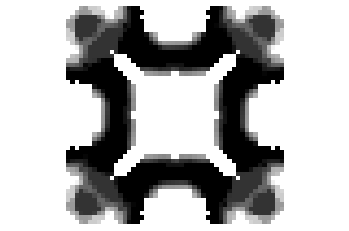

Loop:42 change :0.20000000000000007 mean_Density : 0.5000015449939497 Compliance :-0.017200607445049372


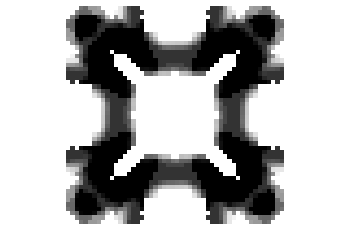

Loop:43 change :0.20000000000000007 mean_Density : 0.4999992632113954 Compliance :-0.017319698484466548


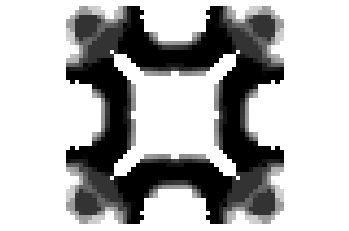

Loop:44 change :0.20000000000000007 mean_Density : 0.5000012497655516 Compliance :-0.017197196329076566


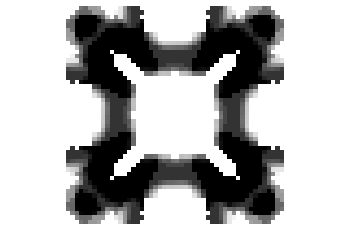

Loop:45 change :0.20000000000000007 mean_Density : 0.49999927137636296 Compliance :-0.017314544282351126


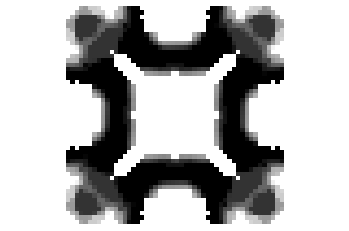

Loop:46 change :0.20000000000000007 mean_Density : 0.500000873738354 Compliance :-0.017194991724564367


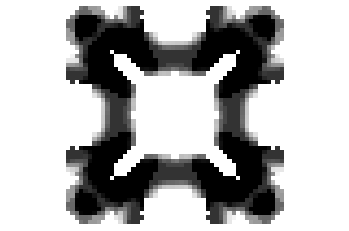

Loop:47 change :0.20000000000000007 mean_Density : 0.49999996157427057 Compliance :-0.017311276835449002


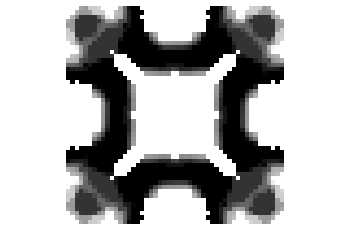

Loop:48 change :0.20000000000000007 mean_Density : 0.5000000401575059 Compliance :-0.01719361568871853


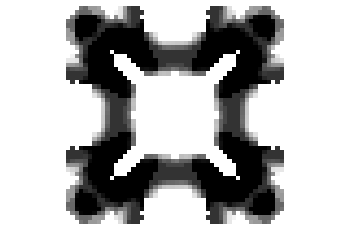

Loop:49 change :0.20000000000000007 mean_Density : 0.5000001032456723 Compliance :-0.017309119439332853


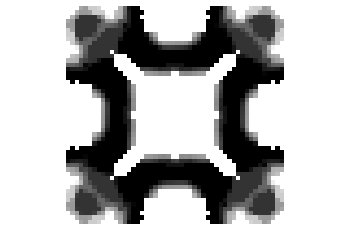

Loop:50 change :0.20000000000000007 mean_Density : 0.5000010601445982 Compliance :-0.017192812507530214


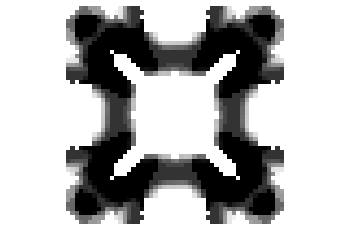

Loop:51 change :0.20000000000000007 mean_Density : 0.4999999332646794 Compliance :-0.017307884730547743


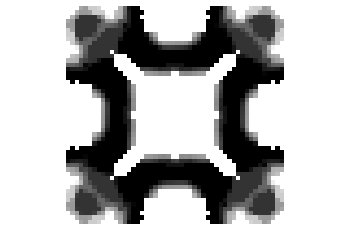

In [3]:
Nx=50;Ny=50
nu=0.3
Eo=1
Emin=1e-9
penal=3
volfrac=0.5
rmin=5
ft=1
# Generation of Input data

Node_matrix,Element_DOF,H_element=input_data(Nx,Ny,rmin)

# Generation of initial density
density=initial_Density(Nx,Ny,volfrac)

# Generation of element stiffness matrix
K_local=Stiffness_local(nu)

# Generation of  DOF for analysis(D1,D2,D3,D4)
D1,D2,D3,D4=BC(Node_matrix,Element_DOF)

# Generation of PBC and values for U_fixed and W_fixed
U_fixed,W_fixed=PBC(Nx,Ny)

# Iteration starts here
loop=0
change=1

while loop <=50:
    
    loop=loop+1
    
    # Generation of Assembly stiffness matrix

    K_G=Global_Stifffness(K_local, Element_DOF,Node_matrix,density)
    
    # FE analysis of the periodic material
    disp=analysis(U_fixed,W_fixed,D1,D2,D3,D4,K_G)

    # calculation of compliance and their derivative
    C,dC,dV=strain_energy(disp,Element_DOF,density)

    # Applying filters/modification to sensivity analysis
    dC_filtered,dV_filtered=filteration(dC,dV,H_element,density)

    #Applying  Optimal criteria method to update physical variables
    density_new=optimal_criteria(dC_filtered,dV_filtered,density,H_element)

    # Evaluating the change between new and old density

    change=np.max(np.abs(density-density_new))
    density=density_new.copy()
    
    print(f"Loop:{loop} change :{change} mean_Density : { np.mean(density)} Compliance :{C}")
    
    # Plot the densities of all the elements
    plt.imshow(1-density_new, cmap='gray', vmin=0, vmax=1)
    plt.axis('equal')
    plt.axis('off')
    plt.show()

